# Training a Model on Wideband for Signal Detection

This notebook demonstrates how to train a YOLO model on the Wideband dataset for energy detection using spectrograms.

---

In [1]:
%matplotlib inline

## Create the Wideband Dataset for YOLO

We are going to use an infinite NewWideband dataset to generate both our train and validation datasets by writing the images and labels to disk how [YOLO expects them to be](https://docs.ultralytics.com/yolov5/tutorials/train_custom_data/#option-2-create-a-manual-dataset).

In [2]:
# Variables
from torchsig.transforms.dataset_transforms import Spectrogram
from torchsig.transforms.target_transforms import YOLOLabel
from torchsig.signals.signal_lists import TorchSigSignalLists
from tqdm.notebook import tqdm

root = "./datasets/wideband_detector_example"
fft_size = 1024
num_iq_samples_dataset = fft_size ** 2
class_list = TorchSigSignalLists.all_signals
num_classes = len(class_list)
num_train = 100 # size of train dataset
num_val = 10 # size of validation dataset

# transform data into a spectrogram image
transforms = [Spectrogram(fft_size=fft_size)]
# YOLO labels are expected to be (class index, x center, y center, width, height)
# all normalized to zero, with (0,0) being upper left corner
target_transforms = [YOLOLabel()]

Data shape: (1024, 1024)
Number of signals: 3
Labels:
(5, 0.6476359367370605, 0.1946512538424635, 0.551966667175293, 0.3893025075849271)
(25, 0.3455696105957031, 0.6370501832651194, 0.38179969787597656, 0.2041015625)
(0, 0.6296663284301758, 0.5351989671595787, 0.3576221466064453, 0.9296020656808425)


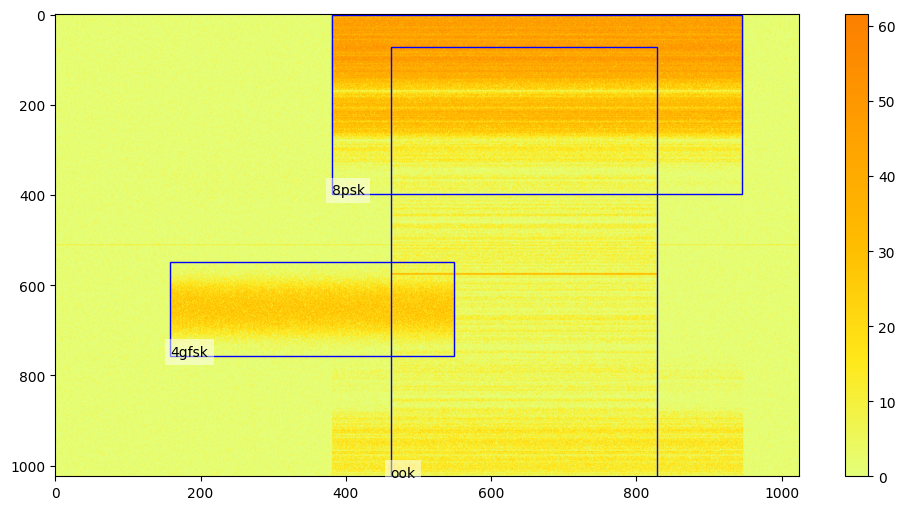

In [3]:
from torchsig.datasets.dataset_metadata import WidebandMetadata
from torchsig.datasets.datamodules import WidebandDataModule
from torchsig.datasets.wideband import NewWideband

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# create the NewWideband dataset
dataset_metadata = WidebandMetadata(
    num_iq_samples_dataset = num_iq_samples_dataset,
    fft_size = fft_size,
    impairment_level = 2,
    num_signals_max = 3,
    transforms=transforms,
    target_transforms=target_transforms,
)

wideband = NewWideband(
    dataset_metadata = dataset_metadata
)

# show sample from dataset
data, label = wideband[0]
print(f"Data shape: {data.shape}")
print(f"Number of signals: {len(label)}")
nl = "\n"
print(f"Labels:\n{nl.join(str(l) for l in label)}")

height, width = data.shape
fig = plt.figure(figsize=(12,6))
fig.tight_layout()

ax = fig.add_subplot(1,1,1)
pos = ax.imshow(data,aspect='auto',cmap='Wistia',vmin=dataset_metadata.noise_power_db)

fig.colorbar(pos, ax=ax)


for t in label:
    classindex, xcenter, ycenter, normwidth, normheight = t


    actualwidth = width * normwidth
    actualheight = height * normheight

    actualxcenter = xcenter * width
    actualycenter = ycenter * height

    x_lowerleft = actualxcenter - (actualwidth / 2)
    y_lowerleft = actualycenter + (actualheight / 2)

    # print(x_lowerleft, y_lowerleft, actualwidth, actualheight)

    ax.add_patch(Rectangle(
        (x_lowerleft, y_lowerleft), 
        actualwidth, 
        -actualheight,
        linewidth=1, 
        edgecolor='blue', 
        facecolor='none'
    ))

    textDisplay = str(class_list[classindex])
    ax.text(x_lowerleft,y_lowerleft,textDisplay, bbox=dict(facecolor='w', alpha=0.5, linewidth=0))

plt.show()


In [4]:
import cv2
import shutil
import os

# writes the images to disk under images/
# writes the labels as a txt file under labels/
def prepare_dataset(dataset, train: bool, root: str, start_index: int, stop_index: int):
    os.makedirs(root, exist_ok = True)
    train_path = "train" if train else "val"
    label_dir = f"{root}/labels/{train_path}"
    image_dir = f"{root}/images/{train_path}"
    os.makedirs(label_dir, exist_ok = True)
    os.makedirs(image_dir, exist_ok = True)

    for i in tqdm(range(start_index, stop_index), desc=f"Writing YOLO {train_path.title()} Dataset"):
        image, labels = dataset[i]
        filename_base = str(i).zfill(10)
        label_filename = f"{label_dir}/{filename_base}.txt"
        image_filename = f"{image_dir}/{filename_base}.png"

        with open(label_filename, "w") as f:
            line = ""
            f.write("\n".join(f"{x[0]} {x[1]} {x[2]} {x[3]} {x[4]}" for x in labels))
        cv2.imwrite(image_filename, image, [cv2.IMWRITE_PNG_COMPRESSION, 9])

if os.path.exists(root):
    shutil.rmtree(root)

prepare_dataset(wideband, train=True, root=root, start_index=1, stop_index = num_train)
prepare_dataset(wideband, train=False, root=root, start_index=num_train, stop_index = num_train + num_val)


Writing YOLO Train Dataset:   0%|          | 0/99 [00:00<?, ?it/s]

Writing YOLO Val Dataset:   0%|          | 0/10 [00:00<?, ?it/s]

In [5]:
# create dataset yaml file for ultralytics
import yaml
import torch

config_name = "wideband_detector_yolo.yaml"
classes = {v: k for v,k in enumerate(class_list)}

yolo_config = dict(
    path = "wideband_detector_example",
    train = "images/train",
    val = "images/val",
    nc = num_classes,
    names = classes
)

with open(config_name, 'w+') as file:
    yaml.dump(yolo_config, file, default_flow_style=False)

## Prepare the YOLO Model

Below we download the `yolo8x.pt` model (YOLOv8) if it does not exist already, and then instantiate the model.

In [6]:
import requests
import os

url = "https://github.com/ultralytics/assets/releases/download/v8.2.0/yolov8x.pt"
model_filepath = "yolov8x.pt"

if not os.path.exists(model_filepath):
    print(f"Downloading yolov8x.pt from {url}...")
    response = requests.get(url)
    if response.status_code == 200:
        # Write the content to the local file
        with open(model_filepath, 'wb') as file:
            file.write(response.content)
        print(f"File downloaded and saved to: {model_filepath}")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")
else:
    print(f"{model_filepath} exists")


yolov8x.pt exists


In [7]:
# instantiate the model
from ultralytics import YOLO

model = YOLO(model_filepath)

## Train

Train the YOLO model. See [Ultralytics Train](https://docs.ultralytics.com/modes/train/#train-settings) for training hyperparameter options.

In [ ]:
results = model.train(
    data=config_name, 
    epochs=20, 
    batch=1,
    imgsz=fft_size,
    device=0 if torch.cuda.is_available() else "cpu",
    workers=1,
    project="yolo",
    name="wideband_detector_example"
)

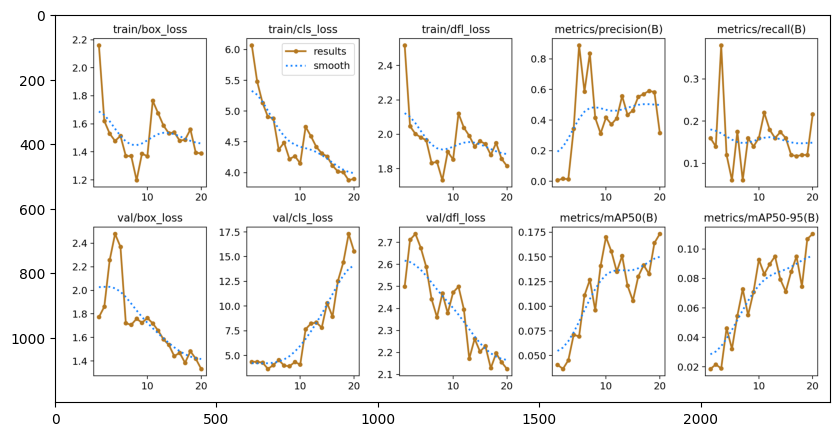

In [9]:
# View the training progress and performance
import matplotlib.pyplot as plt
import cv2
import os

results_img = cv2.imread(os.path.join(results.save_dir, "results.png"))
plt.figure(figsize = (10,20))
plt.imshow(results_img)

## Evaluation

We can now use the model to detect signals on spectrogram images. Try running more epochs or a larger dataset for improved performance.

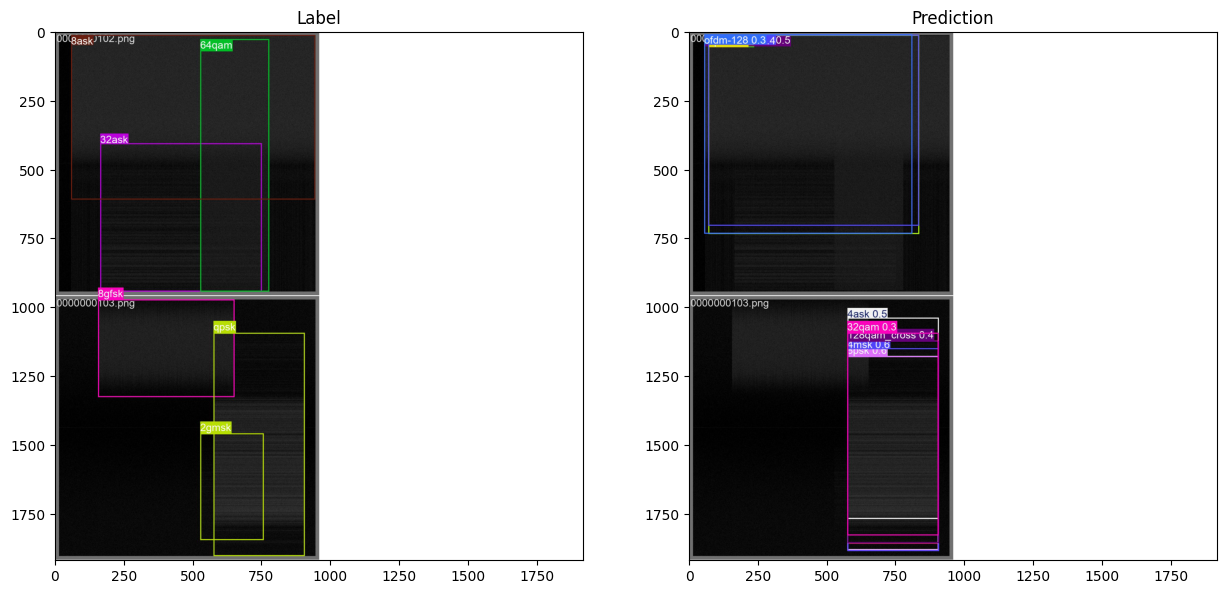

In [14]:
label = cv2.imread(os.path.join(results.save_dir, "val_batch1_labels.jpg"))
pred = cv2.imread(os.path.join(results.save_dir, "val_batch1_pred.jpg"))

f, ax = plt.subplots(1, 2, figsize=(15, 9))
ax[0].imshow(label)
ax[0].set_title("Label")
ax[1].imshow(pred)
ax[1].set_title("Prediction")
plt.show()